In [1]:
from __future__ import division

import numpy as np
import os
from glob import glob

from PIL import Image
from copy import deepcopy

from sklearn import linear_model, datasets, neighbors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm

%matplotlib inline
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import pandas as pd

import scipy.stats as stats
from scipy.stats import norm
import sklearn

In [2]:
## define path to input datasets (tidy format) (see analysis_helpers.py) for definitions
path_to_recog = '/home/jefan/neurosketch/neurosketch_voxelmat_freesurfer_recog'
path_to_draw = '/home/jefan/neurosketch/neurosketch_voxelmat_freesurfer_drawing'
roi_list = np.array(['V1','V2','LOC','IT','fusiform','parahippo', 'PRC', 'ento','hipp','mOFC'])

In [3]:
## get raw file list for recognition runs
RECOG_METAS = sorted([i for i in os.listdir(path_to_recog) if i.split('.')[-1]=='csv'])
RECOG_FEATS = sorted([i for i in os.listdir(path_to_recog) if i.split('.')[-1]=='npy'])
RECOG_SUBS = np.array([i.split('_')[0] for i in RECOG_FEATS])

recog_sub_list = np.unique(RECOG_SUBS)

def preprocess_recog(RECOG_METAS, RECOG_FEATS):
    M = [i for i in RECOG_METAS if len(i.split('.')[0].split('_'))==4]
    F = [i for i in RECOG_FEATS if len(i.split('.')[0].split('_'))==4]
    return M,F

RECOG_METAS, RECOG_FEATS = preprocess_recog(RECOG_METAS, RECOG_FEATS)

In [4]:
## get raw file list for drawing runs
DRAW_METAS = sorted([i for i in os.listdir(path_to_draw) if i.split('.')[-1]=='csv'])
DRAW_FEATS = sorted([i for i in os.listdir(path_to_draw) if i.split('.')[-1]=='npy'])
DRAW_SUBS = np.array([i.split('_')[0] for i in DRAW_FEATS])
draw_sub_list = np.unique(DRAW_SUBS)

In [5]:
## get subject ID's that have complete datasets from all phases of experiment
sub_list = np.intersect1d(recog_sub_list,draw_sub_list)
print 'Number of subs: {}'.format(len(sub_list))

Number of subs: 31


In [6]:
## filter file list so only contains the sessions that have full datasets
def extract_good_sessions(DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS):
    _DRAW_METAS = [i for i in DRAW_METAS if i.split('_')[1] in sub_list]
    _DRAW_FEATS = [i for i in DRAW_FEATS if i.split('_')[0] in sub_list]
    _RECOG_METAS = [i for i in RECOG_METAS if i.split('_')[1] in sub_list]
    _RECOG_FEATS = [i for i in RECOG_FEATS if i.split('_')[0] in sub_list]
    return _DRAW_METAS, _DRAW_FEATS, _RECOG_METAS, _RECOG_FEATS

DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS =  \
extract_good_sessions(DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS)

RECOG_SUBS = np.array([i.split('_')[0]+'_neurosketch' for i in RECOG_FEATS])
RECOG_ROIS = np.array([i.split('_')[1] for i in RECOG_FEATS])

DRAW_SUBS = np.array([i.split('_')[0]+'_neurosketch' for i in DRAW_FEATS])
DRAW_ROIS = np.array([i.split('_')[1] for i in DRAW_FEATS])

### How well do we do at classifying the target when we train on recognition patterns only?

In [7]:
#### Helper data loader functions
def load_draw_meta(this_sub):
    this_file = 'metadata_{}_drawing.csv'.format(this_sub)
    x = pd.read_csv(os.path.join(path_to_draw,this_file))
    x = x.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
    x['trial_num'] = np.repeat(np.arange(40),23)        
    return x
    
def load_draw_feats(this_sub,this_roi):
    this_file = '{}_{}_featurematrix.npy'.format(this_sub,this_roi)
    y = np.load(os.path.join(path_to_draw,this_file))
    y = y.transpose()
    return y

def load_draw_data(this_sub,this_roi):
    x = load_draw_meta(this_sub)
    y = load_draw_feats(this_sub,this_roi)
    assert y.shape[0] == x.shape[0]    
    return x,y

def load_recog_meta(this_sub,this_roi,this_phase):
    this_file = 'metadata_{}_{}_{}.csv'.format(this_sub,this_roi,this_phase)
    x = pd.read_csv(os.path.join(path_to_recog,this_file))
    x = x.drop(['Unnamed: 0'], axis=1)
    return x
    
def load_recog_feats(this_sub,this_roi,this_phase):
    this_file = '{}_{}_{}_featurematrix.npy'.format(this_sub,this_roi,this_phase)
    y = np.load(os.path.join(path_to_recog,this_file))
    y = y.transpose()
    return y    

def load_recog_data(this_sub,this_roi,this_phase):
    x = load_recog_meta(this_sub,this_roi,this_phase)
    y = load_recog_feats(this_sub,this_roi,this_phase)
    assert y.shape[0] == x.shape[0]    
    return x,y

# z-score normalization to de-mean & standardize variances within-voxel 
def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X

## plotting helper
def get_prob_timecourse(iv,DM,version='4way'):
    trained_objs = np.unique(DM.label.values)
    control_objs = [i for i in ['bed','bench','chair','table'] if i not in trained_objs]    
    
    if version=='4way':
        t1 = trained_objs[0]
        t2 = trained_objs[1]
        c1 = control_objs[0]
        c2 = control_objs[1]
        target = np.vstack((DM[DM.label==t1].groupby(iv)['t1_prob'].mean().values,
                       DM[DM.label==t2].groupby(iv)['t2_prob'].mean().values)).mean(0) ## target timecourse
        foil = np.vstack((DM[DM.label==t1].groupby(iv)['t2_prob'].mean().values,
                       DM[DM.label==t2].groupby(iv)['t1_prob'].mean().values)).mean(0) ## foil timecourse
        control = np.vstack((DM[DM.label==t1].groupby(iv)['c1_prob'].mean().values,
                            DM[DM.label==t1].groupby(iv)['c2_prob'].mean().values,
                            DM[DM.label==t2].groupby(iv)['c1_prob'].mean().values,
                            DM[DM.label==t2].groupby(iv)['c2_prob'].mean().values)).mean(0) ## control timecourse    
    elif version=='3way':
        t1 = trained_objs[0]
        t2 = trained_objs[1]
        target = np.vstack((DM[DM.label==t1].groupby(iv)['t1_prob'].mean().values,
                       DM[DM.label==t2].groupby(iv)['t2_prob'].mean().values)).mean(0) ## target timecourse; mean is taken over what?
        foil = np.vstack((DM[DM.label==t1].groupby(iv)['t2_prob'].mean().values,
                       DM[DM.label==t2].groupby(iv)['t1_prob'].mean().values)).mean(0) ## foil timecourse
        control = np.vstack((DM[DM.label==t1].groupby(iv)['c_prob'].mean().values,
                            DM[DM.label==t2].groupby(iv)['c_prob'].mean().values)).mean(0) ## control timecourse
        
    elif version=='2way':
        t1 = trained_objs[0]
        t2 = trained_objs[1]
        target = np.vstack((DM[DM.label==t1].groupby(iv)['t1_prob'].mean().values,
                       DM[DM.label==t2].groupby(iv)['t2_prob'].mean().values)).mean(0) ## target timecourse; mean is taken over what?
        foil = np.vstack((DM[DM.label==t1].groupby(iv)['t2_prob'].mean().values,
                       DM[DM.label==t2].groupby(iv)['t1_prob'].mean().values)).mean(0) ## foil timecourse
        
        control = np.zeros(len(foil))        
        
    return target, foil, control
     
def flatten(x):
    return [item for sublist in x for item in sublist]    

In [8]:
## general plotting params
sns.set_context('poster')
colors = sns.color_palette("cubehelix", 5)

In [9]:
## example subject, roi, and phase (localizer is default)
this_sub = sub_list[0]
this_roi = roi_list[2] ## order is: ['V1','V2','LOC','IT','fusiform','parahippo', 'PRC', 'ento','hipp','mOFC']
this_phase = '12' ## options are '12', '34', '56'

### generate big ALLDM supersubject matrix with classifier probabilities

In [12]:
really_run = 0
if really_run:
    import analysis_helpers
    reload(analysis_helpers)
    roi_list_short = roi_list
    sub_list_short = sub_list
    version = '4way'
    ALLDM, Acc = analysis_helpers.make_drawing_predictions(sub_list_short,roi_list_short,version=version)
    
    # ALLDM = ALLDM.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)
    ALLDM.head()
    ALLDM.to_csv('./logistic_timeseries_drawing_neural_{}.csv'.format(version)) ## train recog, test drawing run    

V1
V2
LOC
IT
fusiform
parahippo
PRC
ento
hipp
mOFC


In [13]:
Acc = np.array(Acc)
x = pd.DataFrame(Acc.transpose())
x.columns = roi_list_short

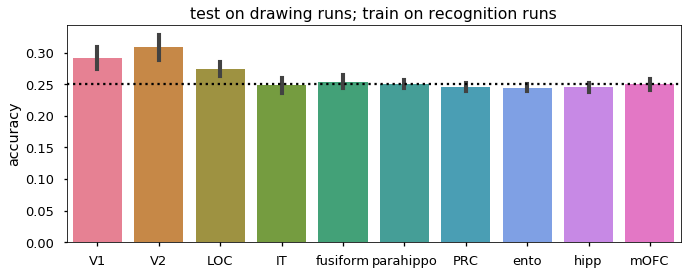

In [14]:
sns.set_context('talk')
plt.figure(figsize=(11,4))
sns.barplot(data=x,palette='husl',ci=95)
chance_dict = {'4way':0.25,'3way':0.33,'2way':0.5}
plt.axhline(chance_dict[version],linestyle=':',color='k')
plt.ylabel('accuracy')
plt.title('test on drawing runs; train on recognition runs')
# plt.ylim(0,0.35)

#### make summary timecourse plots


In [15]:
run_this = 0

if run_this:
    sns.set_context('paper')
    this_roi = 'V1'
    subs = np.unique(ALLDM.subj.values)
    lookup = dict(zip(['trial_num','run_num','time_point'],['repetition','run','TR']))
    ivs = ['run_num','trial_num','time_point']
    this_iv = 'time_point'

    ## do you want to render the CONDITION-wise plots -- trained vs. foil vs control
    ## or the DIFFERENCE plots -- trained - foil vs foil - control?
    render_cond = 1

    for this_iv in ivs:
        for this_roi in roi_list_short:

            T = []
            F = []
            C = []
            Sub = []
            for sub in subs:
                inds =(ALLDM['roi']==this_roi) & (ALLDM['subj']==sub) 
                t,f,c = get_prob_timecourse(this_iv,ALLDM[inds],version=version)
                if len(T)==0:
                    T = t
                    F = f
                    C = c
                    DTF = t-f  ## these differences already in log space       
                    DTC = t-c
                    DFC = f-c
                else:
                    T = np.hstack((T,t))
                    F = np.hstack((F,f))        
                    C = np.hstack((C,c)) 
                    DTF = np.hstack((DTF,t-f))                
                    DTC = np.hstack((DTC,t-c))
                    DFC = np.hstack((DFC,f-c))
                Sub.append([sub]*len(t))   

            if render_cond==1:
                ## make longform version of dataframe to use in tsplot (by condition)            
                Trial = np.tile(np.arange(len(t)),len(subs)*3)
                Condition = np.repeat(['target','foil','control'],len(T))
                Sub = np.tile(np.array(flatten(Sub)),3)
                Prob = np.hstack((T,F,C))
                assert len(Trial)==len(Condition)
                assert len(Sub)==len(Prob)
                assert len(Condition)==len(Sub)
                x = pd.DataFrame([Prob,Trial,Condition,Sub])
                x = x.transpose()
                x.columns = ['probability',lookup[this_iv],'condition','sub']
                toop = 'condition'            
            else:
                ## make longform version of dataframe to use in tsplot (difference btw conditions)                    
                Trial = np.tile(np.arange(len(t)),len(subs)*3)
                Condition = np.repeat(['target-foil','target-control','foil-control'],len(T))
                Sub = np.tile(np.array(flatten(Sub)),3)
                Prob = np.hstack((DTF,DTC,DFC))        
                assert len(Trial)==len(Condition)
                assert len(Sub)==len(Prob)
                assert len(Condition)==len(Sub)
                x = pd.DataFrame([Prob,Trial,Condition,Sub])
                x = x.transpose()
                x.columns = ['probability',lookup[this_iv],'condition','sub']        
                toop = 'difference'
            fig = plt.figure(figsize=(8,4))
            ## plot it
            sns.tsplot(data=x,
                      time=lookup[this_iv],
                      unit='sub',
                      condition='condition',
                      value='probability',
                      ci=95)
            if render_cond==1:
                plt.ylim(0,0.5)
                plt.axhline(0.25,linestyle=':',color='k')  
                plt.legend(bbox_to_anchor=(0.8, 1.01))  
                plt.title('Classifier evidence by condition in {}'.format(this_roi))

            else:
                plt.ylim(-0.3,0.3)
                plt.axhline(0,linestyle=':',color='k')  
                plt.legend(bbox_to_anchor=(0.7, 1.01))                        
                plt.title('Difference in classifier evidence by condition in {}'.format(this_roi))        
            plt.xticks(np.arange(np.max(x[lookup[this_iv]].values)+1))
            if not os.path.exists('./plots/roi/{}/{}'.format(lookup[this_iv],toop)):
                os.makedirs('./plots/roi/{}/{}'.format(lookup[this_iv],toop))
            plt.tight_layout()        
            plt.savefig('./plots/roi/{}/{}/prob_timecourse_{}_by_{}_{}.pdf'.\
                        format(lookup[this_iv],toop,this_roi,lookup[this_iv],version))
            plt.close(fig)

#### get subject-level index of contrast between objects during drawing


In [19]:
lookup = dict(zip(['trial_num','run_num','time_point'],['repetition','run','TR']))
version = '4way'
ALLDM = pd.read_csv('./logistic_timeseries_drawing_neural_{}.csv'.format(version))

In [20]:
ALLDM.head()

,Unnamed: 0,TR_num,Unnamed: 0.1.1,c1_prob,c2_prob,label,roi,run_num,subj,t1_prob,t2_prob,time_point,trial_num
0,0,10,NaN,-4.559790,-1.661495,bed,V1,1,110171,-0.240906,-4.285586,1,0
1,1,11,NaN,-4.365711,-3.466332,bed,V1,1,110171,-0.058221,-4.372367,2,0
2,2,12,NaN,-3.877128,-0.450481,bed,V1,1,110171,-1.497240,-2.135194,3,0
3,3,13,NaN,-10.338838,-0.593861,bed,V1,1,110171,-3.994277,-0.845469,4,0
4,4,14,NaN,-2.914796,-0.605683,bed,V1,1,110171,-0.918028,-7.159800,5,0


In [21]:
sub_tf = []
sub_tc = []
sub_fc = []
roi = []

subs = np.unique(ALLDM.subj.values)
ivs = ['time_point'] ## other options 'run_num','trial_num',

## do you want to render the CONDITION-wise plots -- trained vs. foil vs control
## or the DIFFERENCE plots -- trained - foil vs foil - control?
render_cond = 0

for this_iv in ivs:
    for this_roi in roi_list_short:

        T = []
        F = []
        C = []
        Sub = []
        for sub in subs:
            inds =(ALLDM['roi']==this_roi) & (ALLDM['subj']==sub) 
            t,f,c = get_prob_timecourse(this_iv,ALLDM[inds],version=version)
            if len(T)==0:
                T = t
                F = f
                C = c
                DTF = t-f               
                DTC = t-c
                DFC = f-c
            else:
                T = np.hstack((T,t))
                F = np.hstack((F,f))        
                C = np.hstack((C,c)) 
                DTF = np.hstack((DTF,t-f))                
                DTC = np.hstack((DTC,t-c))
                DFC = np.hstack((DFC,f-c))
            Sub.append([sub]*len(t))   
          
        ## make longform version of dataframe to use in tsplot (difference btw conditions)                    
        Trial = np.tile(np.arange(len(t)),len(subs)*3)
        Condition = np.repeat(['target-foil','target-control','foil-control'],len(T))
        Sub = np.tile(np.array(flatten(Sub)),3)
        Prob = np.hstack((DTF,DTC,DFC))        
        assert len(Trial)==len(Condition)
        assert len(Sub)==len(Prob)
        assert len(Condition)==len(Sub)
        x = pd.DataFrame([Prob,Trial,Condition,Sub])
        x = x.transpose()
        x.columns = ['probability',lookup[this_iv],'condition','sub']
        
        for this_sub in subs:
            sub_tf.append(x[(x['condition']=='target-foil') & (x['sub']==this_sub)]['probability'].mean())
            sub_tc.append(x[(x['condition']=='target-control') & (x['sub']==this_sub)]['probability'].mean())  
            sub_fc.append(x[(x['condition']=='foil-control') & (x['sub']==this_sub)]['probability'].mean()) 
            roi.append(this_roi)
            
## make dataframe with subject-level difference scores
d = pd.DataFrame([sub_tf,sub_tc,sub_fc,roi])
d = d.transpose()
d.columns = ['target-foil','target-control','foil-control','roi']
d = d.astype({'target-foil':'float64','target-control':'float64','foil-control':'float64'})

## print out target-foil ratios
print d.groupby('roi')['target-foil'].apply(lambda x: np.mean(np.exp(x)))
d.to_csv('difference_logprobs_{}.csv'.format(version))

roi
IT           1.085609
LOC          1.656466
PRC          0.974224
V1           2.067077
V2           2.639313
ento         0.979692
fusiform     1.191058
hipp         0.953376
mOFC         1.041864
parahippo    1.038173
Name: target-foil, dtype: float64


In [22]:
run_this = 0
if run_this:
    ## comparing 4-way and 2-way probability ratios
    d4way = pd.read_csv('difference_logprobs_4way.csv')
    d2way = pd.read_csv('difference_logprobs_2way.csv')
    inds = d4way['roi']=='V2'
    plt.scatter(d4way[inds]['target-foil'],d2way[inds]['target-foil'])

In [38]:
def bootstrapCI(x,nIter):
    '''
    input: x is an array
    '''
    u = []
    for i in np.arange(nIter):
        inds = np.random.RandomState(i).choice(len(x),len(x))
        boot = x[inds]
        u.append(np.mean(boot))
        
    U = np.mean(u)
    lb = np.percentile(u,2.5)
    ub = np.percentile(u,97.5) 
    return U,lb,ub

In [46]:
for this_roi in roi_list:
    data = d[d['roi']==this_roi]['target-foil'].values
    U,lb,ub = bootstrapCI(data,1000)
    print 'ROI = {} | mean = {}  95% CI: [{} {}] '.format(this_roi,np.round(U,3),np.round(lb,3),np.round(ub,3))

ROI = V1 | mean = 0.424  95% CI: [0.174 0.703] 
ROI = V2 | mean = 0.569  95% CI: [0.287 0.879] 
ROI = LOC | mean = 0.41  95% CI: [0.239 0.572] 
ROI = IT | mean = 0.054  95% CI: [-0.026 0.134] 
ROI = fusiform | mean = 0.148  95% CI: [0.062 0.235] 
ROI = parahippo | mean = 0.023  95% CI: [-0.035 0.082] 
ROI = PRC | mean = -0.044  95% CI: [-0.105 0.018] 
ROI = ento | mean = -0.055  95% CI: [-0.155 0.038] 
ROI = hipp | mean = -0.069  95% CI: [-0.152 0.004] 
ROI = mOFC | mean = 0.006  95% CI: [-0.094 0.101] 


In [47]:
for this_roi in roi_list:
    data = d[d['roi']==this_roi]['target-control'].values
    U,lb,ub = bootstrapCI(data,1000)
    print 'ROI = {} | mean = {}  95% CI: [{} {}] '.format(this_roi,np.round(U,3),np.round(lb,3),np.round(ub,3))

ROI = V1 | mean = 0.206  95% CI: [0.055 0.378] 
ROI = V2 | mean = 0.28  95% CI: [0.084 0.463] 
ROI = LOC | mean = 0.235  95% CI: [0.112 0.366] 
ROI = IT | mean = 0.097  95% CI: [0.029 0.164] 
ROI = fusiform | mean = 0.061  95% CI: [0.005 0.118] 
ROI = parahippo | mean = -0.005  95% CI: [-0.071 0.051] 
ROI = PRC | mean = -0.002  95% CI: [-0.069 0.062] 
ROI = ento | mean = 0.037  95% CI: [-0.056 0.117] 
ROI = hipp | mean = -0.0  95% CI: [-0.065 0.059] 
ROI = mOFC | mean = -0.039  95% CI: [-0.112 0.032] 


In [48]:
for this_roi in roi_list:
    data = d[d['roi']==this_roi]['foil-control'].values
    U,lb,ub = bootstrapCI(data,1000)
    print 'ROI = {} | mean = {}  95% CI: [{} {}] '.format(this_roi,np.round(U,3),np.round(lb,3),np.round(ub,3))

ROI = V1 | mean = -0.218  95% CI: [-0.362 -0.068] 
ROI = V2 | mean = -0.29  95% CI: [-0.466 -0.115] 
ROI = LOC | mean = -0.175  95% CI: [-0.291 -0.06] 
ROI = IT | mean = 0.042  95% CI: [-0.027 0.115] 
ROI = fusiform | mean = -0.087  95% CI: [-0.159 -0.015] 
ROI = parahippo | mean = -0.028  95% CI: [-0.095 0.034] 
ROI = PRC | mean = 0.042  95% CI: [-0.004 0.082] 
ROI = ento | mean = 0.092  95% CI: [0.011 0.173] 
ROI = hipp | mean = 0.068  95% CI: [0.023 0.117] 
ROI = mOFC | mean = -0.046  95% CI: [-0.12 0.03] 


### read in pre-post changes

In [60]:
d = pd.read_csv('difference_logprobs_2way.csv')
prepost = pd.read_csv('neural_changes_by_surfroi_and_subject.csv')

In [61]:
# h = plt.hist(d[d['roi']=='V1']['target-foil'].values)

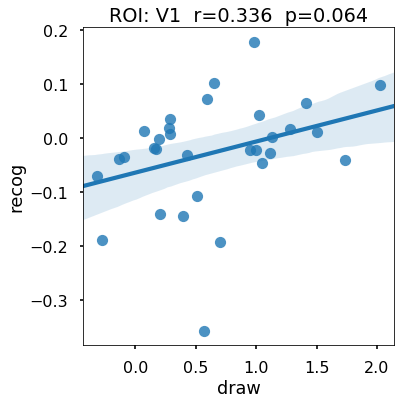

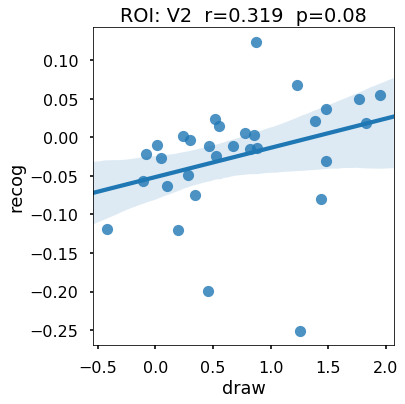

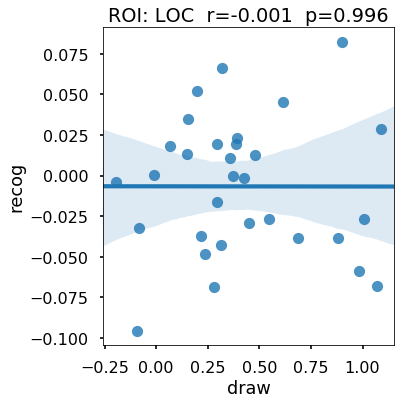

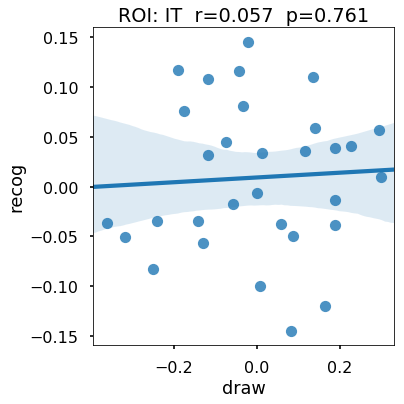

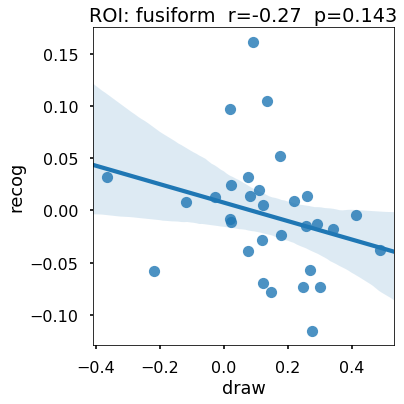

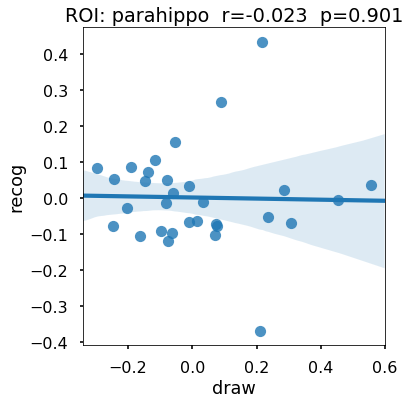

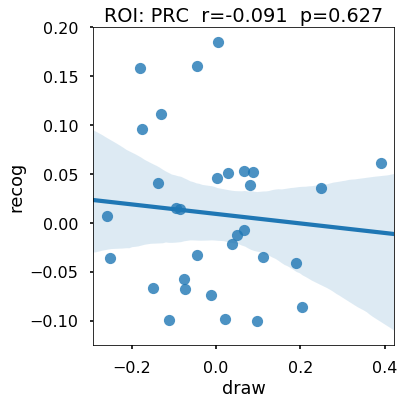

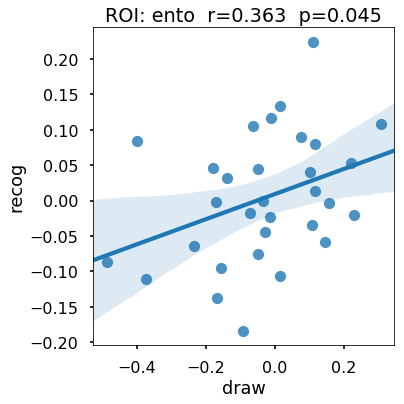

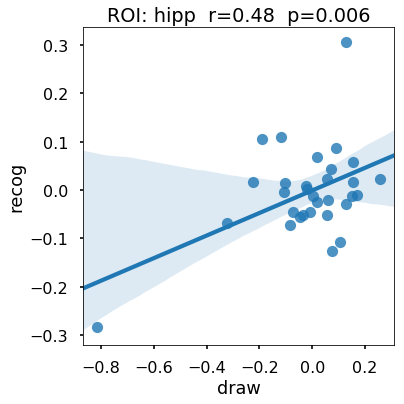

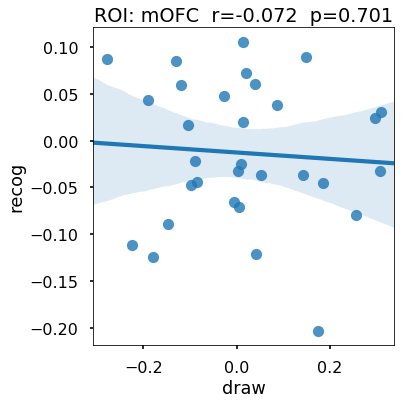

In [62]:
## make dataframe to relate drawing contrast to recognition differentiation
roi_list = ['V1', 'V2', 'LOC', 'IT', 'fusiform', 'parahippo', 'PRC', 'ento','hipp', 'mOFC']
this_roi = 'hipp'

for this_roi in roi_list:
#     draw = d[d['roi']==this_roi]['target-control'].values - d[d['roi']==this_roi]['foil-control'].values
    draw = d[d['roi']==this_roi]['target-foil'].values
    recog = prepost['tradiff_{}'.format(this_roi)].values-prepost['condiff_{}'.format(this_roi)].values
#     recog = prepost['tradiff_{}'.format(this_roi)].values

    z = pd.DataFrame([draw,recog])
    z = z.transpose()
    z.columns=['draw','recog']

    ## plot 
    fig = plt.figure(figsize=(6,6))
    sns.set_context('poster')
    sns.regplot(x="draw",
                y ="recog",
                data=z)
    r,p = stats.pearsonr(draw,recog)
    plt.title('ROI: {}  r={}  p={}'.format(this_roi,np.round(r,3),np.round(p,3)))
    if not os.path.exists('./plots/roi/drawrecog'):
        os.makedirs('./plots/roi/drawrecog')
    plt.tight_layout()
#     plt.savefig('./plots/roi/drawrecog/draw_recog_scatter_{}.pdf'.format(this_roi))
#     plt.close(fig)        

### relate neural to vgg drawing time series

In [178]:
vgg_ts = pd.read_csv('./logistic_timeseries_drawing_vgg.csv')
neural_ts = pd.read_csv('./logistic_timeseries_drawing_neural.csv')

In [179]:
vgg_ts = vgg_ts.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)
vgg_ts.wID = [i.split('_')[0] for i in vgg_ts.wID.values]

In [180]:
vgg_ts.head()

,index,wID,viewpoint,trial,trialDuration,target,competitor,numSketch,bed,bench,chair,table,curr_winner,tc_pair,trialID,run,target_val,competitor_val,control_val
0,0,0119174,20,320,39.00144,bench,chair,0,0.026822,0.055895,0.916243,0.001040,chair,bench/chair,0119174_neurosketch_320,1.0,0.055895,0.916243,0.013931
1,0,0119174,20,320,39.00144,bench,chair,1,0.934225,0.026225,0.039085,0.000465,bed,bench/chair,0119174_neurosketch_320,1.0,0.026225,0.039085,0.467345
2,0,0119174,20,320,39.00144,bench,chair,2,0.006035,0.970770,0.002714,0.020481,bench,bench/chair,0119174_neurosketch_320,1.0,0.970770,0.002714,0.013258
3,0,0119174,20,320,39.00144,bench,chair,3,0.009842,0.978927,0.003784,0.007447,bench,bench/chair,0119174_neurosketch_320,1.0,0.978927,0.003784,0.008644
4,0,0119174,20,320,39.00144,bench,chair,4,0.019298,0.967674,0.001463,0.011564,bench,bench/chair,0119174_neurosketch_320,1.0,0.967674,0.001463,0.015431


In [181]:
## plotting helper
def get_vgg_timecourse(iv,w):
    trained_objs = np.unique(w.target.values)
    control_objs = [i for i in ['bed','bench','chair','table'] if i not in trained_objs]
    t1 = trained_objs[0]
    t2 = trained_objs[1]
    c1 = control_objs[0]
    c2 = control_objs[1]
    target = np.vstack((w[w.target==t1].groupby(iv)['{}'.format(t1)].mean().values,
                   w[w.target==t2].groupby(iv)['{}'.format(t2)].mean().values)).mean(0) ## target timecourse
    foil = np.vstack((w[w.target==t1].groupby(iv)['{}'.format(t2)].mean().values,
                   w[w.target==t2].groupby(iv)['{}'.format(t1)].mean().values)).mean(0) ## foil timecourse
    control = np.vstack((w[w.target==t1].groupby(iv)['{}'.format(c1)].mean().values,
                        w[w.target==t1].groupby(iv)['{}'.format(c2)].mean().values,
                        w[w.target==t2].groupby(iv)['{}'.format(c1)].mean().values,
                        w[w.target==t2].groupby(iv)['{}'.format(c2)].mean().values)).mean(0) ## control timecourse

    return target, foil, control

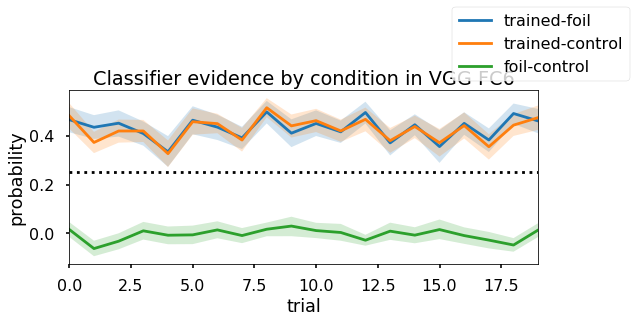

In [182]:
render_cond = 0

## get subject-level index of contrast between objects during drawing
sub_tf = []
sub_tc = []
sub_fc = []
roi = []

T = []
F = []
C = []
Sub = []

this_iv = 'trial' ## options: 'trial' and 'numSketch'
for this_sub in subs:
    inds = (vgg_ts['wID']==this_sub)
    w = vgg_ts[inds]
    t,f,c = get_vgg_timecourse(this_iv,w)
    
    if len(T)==0:
        T = t
        F = f
        C = c
        DTF = t-f                
        DTC = t-c
        DFC = f-c
    else:
        T = np.hstack((T,t))
        F = np.hstack((F,f))        
        C = np.hstack((C,c)) 
        DTF = np.hstack((DTF,t-f))                
        DTC = np.hstack((DTC,t-c))
        DFC = np.hstack((DFC,f-c))
    Sub.append([this_sub]*len(t))   

if render_cond==1:
    ## make longform version of dataframe to use in tsplot (by condition)            
    Trial = np.tile(np.arange(len(t)),len(subs)*3)
    Condition = np.repeat(['trained','foil','control'],len(T))
    Sub = np.tile(np.array(flatten(Sub)),3)
    Prob = np.hstack((T,F,C))
    assert len(Trial)==len(Condition)
    assert len(Sub)==len(Prob)
    assert len(Condition)==len(Sub)
    x = pd.DataFrame([Prob,Trial,Condition,Sub])
    x = x.transpose()
    x.columns = ['probability',this_iv,'condition','sub']
else:
    ## make longform version of dataframe to use in tsplot (difference btw conditions)                    
    Trial = np.tile(np.arange(len(t)),len(subs)*3)
    Condition = np.repeat(['trained-foil','trained-control','foil-control'],len(T))
    Sub = np.tile(np.array(flatten(Sub)),3)
    Prob = np.hstack((DTF,DTC,DFC))        
    assert len(Trial)==len(Condition)
    assert len(Sub)==len(Prob)
    assert len(Condition)==len(Sub)
    x = pd.DataFrame([Prob,Trial,Condition,Sub])
    x = x.transpose()
    x.columns = ['probability',this_iv,'condition','sub']
    
    for this_sub in subs:
        sub_tf.append(x[(x['condition']=='trained-foil') & (x['sub']==this_sub)]['probability'].mean())
        sub_tc.append(x[(x['condition']=='trained-control') & (x['sub']==this_sub)]['probability'].mean())  
        sub_fc.append(x[(x['condition']=='foil-control') & (x['sub']==this_sub)]['probability'].mean()) 
        roi.append('vgg_fc6')
        
    ## make dataframe with subject-level difference scores
    d2 = pd.DataFrame([sub_tf,sub_tc,sub_fc,roi])
    d2 = d2.transpose()
    d2.columns = ['trained-foil','trained-control','foil-control','roi']        

## plot it
fig = plt.figure(figsize=(8,4))
## plot it
sns.tsplot(data=x,
          time=this_iv,
          unit='sub',
          condition='condition',
          value='probability')
# plt.ylim(0,0.5)
plt.axhline(0.25,linestyle=':',color='k')  
plt.legend(bbox_to_anchor=(0.8, 1.01))  
plt.title('Classifier evidence by condition in VGG FC6')
plt.tight_layout()  

In [882]:
## make dataframe to relate drawing contrast to recognition differentiation
roi_list = ['V1', 'V2', 'LOC', 'IT', 'fusiform', 'parahippo', 'PRC', 'ento','hipp', 'mOFC']

for this_roi in roi_list:
    neural = d[d['roi']==this_roi]['trained-control'].values - d[d['roi']==this_roi]['foil-control'].values
    vgg = d2['trained-foil'].values

    z = pd.DataFrame([neural,vgg])
    z = z.transpose()
    z.columns=['neural','vgg']

    ## plot 
    fig = plt.figure(figsize=(6,6))
    sns.set_context('poster')
    sns.regplot(x="neural",
                y ="vgg",
                data=z)
    r,p = stats.pearsonr(neural,vgg)
    plt.title('ROI: {}  r={}  p={}'.format(this_roi,np.round(r,3),np.round(p,3)))
    if not os.path.exists('./plots/roi/neuralvgg'):
        os.makedirs('./plots/roi/neuralvgg')
    plt.tight_layout()
    plt.savefig('./plots/roi/neuralvgg/neural_vgg_scatter_{}.pdf'.format(this_roi))
    plt.close(fig)    
    